In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Defining some key variables that will be used later on in the training
DATASET_NAME = DatasetEnum.GoEmotionsCleaned
CHECKPOINT_DIR = './checkpoints/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + 'bert_model_cleaned_NoReg.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 0
LEARNING_RATE = 5e-05
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET_NAME)
MAX_LEN = compute_max_tokens([train_df, val_df, test_df], BertTokenizer.from_pretrained('bert-base-cased'))
LABEL_COLS = train_df.columns[1:].tolist()

In [3]:
# tuning implicitly done in score calculation :)
def accuracy(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, accuracy_score)
    return best_res

def jaccard(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def jaccard_samples(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'samples', 'zero_division': 0})
    return best_res

def f1(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def f1_micro(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'micro', 'zero_division': 0})
    return best_res
'''
weaker accuracy, each prediction is considered correct if its maximum probability class is one of the true classes
'''
def membership_score(y_true, y_pred):
    n_correct = 0
    for t_pattern, p_pattern in zip(y_true, y_pred):
        n_correct += t_pattern[np.argmax(p_pattern)] == 1
    return n_correct / len(y_true)

In [4]:
# model parameters
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
# creating the 
# we set a seed ti get the sane weight initializzazion for the data prep validation
seed_val = 14
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
                PARAMS)                 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

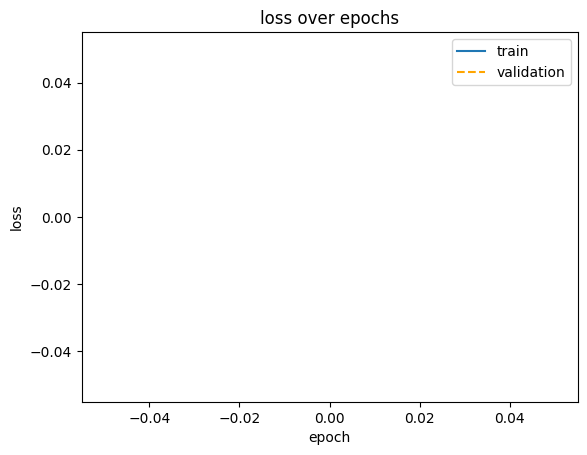

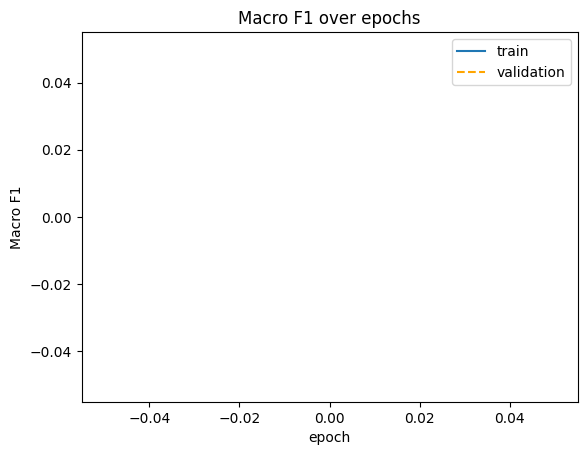

In [5]:
def plot_learning_curves(tr_loss, val_loss, score_name = 'loss'):
    plt.plot(tr_loss, label='train')
    plt.plot(val_loss, label='validation', color='orange', linestyle='--')
    plt.xlabel('epoch')
    plt.ylabel(score_name)
    plt.legend()
    plt.title(f'{score_name} over epochs')
    plt.show()

# plot learning curves
tr_scores, val_scores = model.get_train_scores(), model.get_val_scores()
tr_loss, val_loss = model.get_train_loss(), model.get_val_loss()

plot_learning_curves(tr_loss, val_loss)
plot_learning_curves(tr_scores['f1_macro'], val_scores['f1_macro'], 'Macro F1')

In [7]:
model = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)   
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


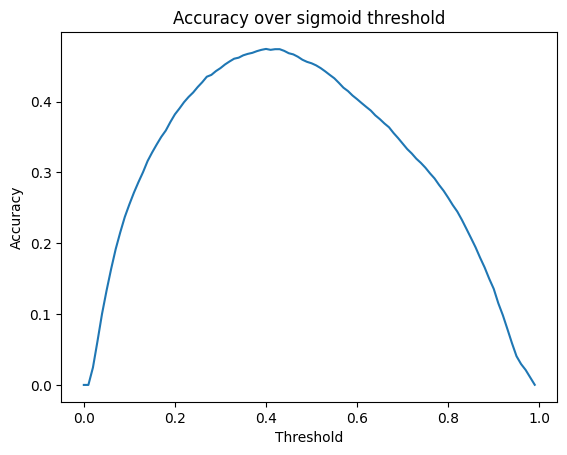

Best threshold: 0.4
Best Accuracy: 0.47438260228529305


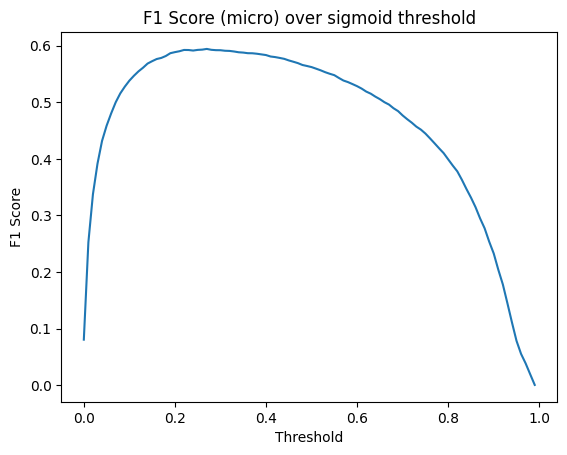

Best threshold: 0.27
Best F1 Score (micro): 0.5942951261510818


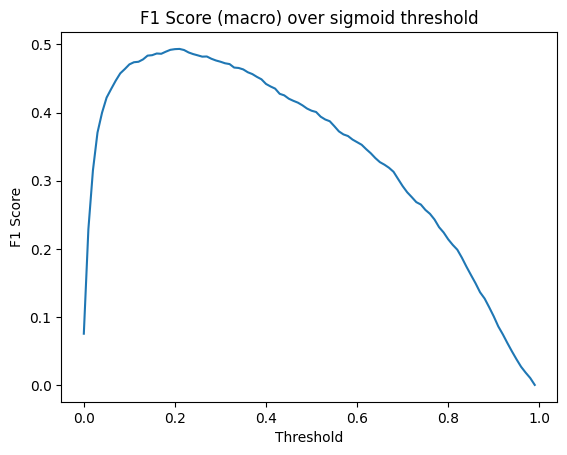

Best threshold: 0.21
Best F1 Score (macro): 0.4933500056794226


In [8]:
plot_threshold_tuning(target, out, plot=True)
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'micro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')

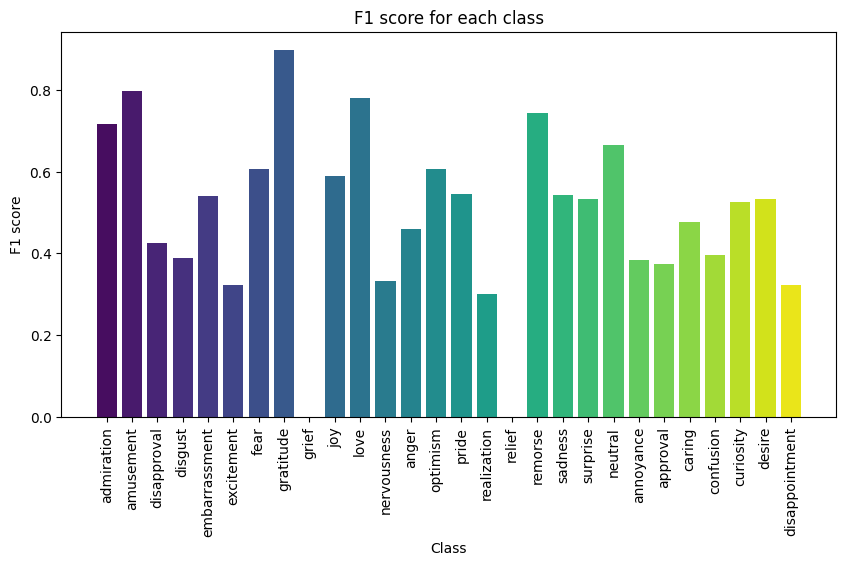

In [10]:
threshold = 0.21
# bar plot over classes

best_out = (out > threshold).astype(int)
plot_score_barplot(target, best_out, LABEL_COLS)

## Goemotions:NoDataCleaning
We try to validate our datacleaning process training a bert model with vanilla tr-set

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.12


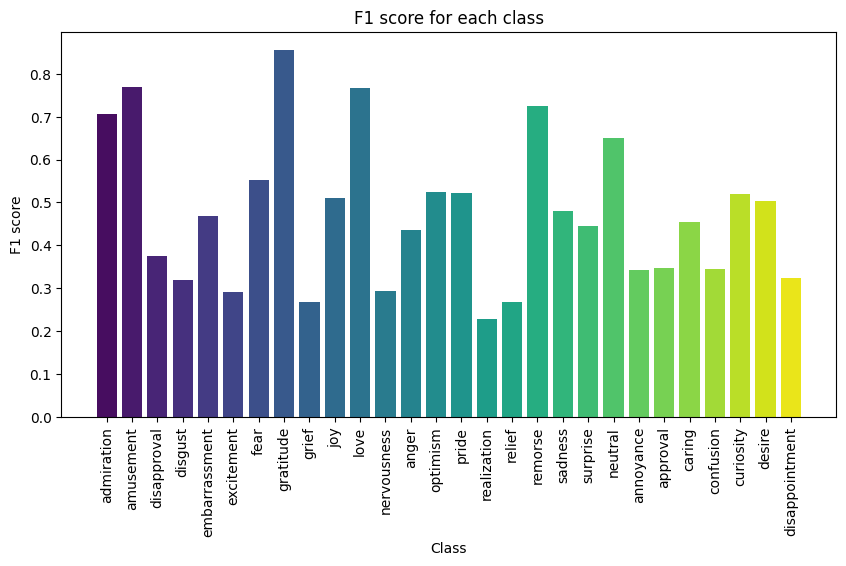

In [4]:
train_df, val_df, test_df = load_goemotions(k_hot_encode=True)
CHECKPOINT_MODEL_FILE_UNCLEANED=CHECKPOINT_DIR + 'bert_model_Uncleaned_NoReg.pth'
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# creating the model with the same seed as the cleaned version
seed_val = 14
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Bert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE_UNCLEANED,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out_uncleaned = model_uncleaned.predict(val_df)
target_uncleaned = val_df.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {thresh_uncleaned}")
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
plot_score_barplot(target_uncleaned, best_out_uncleaned, LABEL_COLS)

Now we can compare the graphical results of the obtained models

In [7]:
_,_, test_df_uncleaned = load_goemotions(k_hot_encode=True)
_,_, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)

thresh_cleaned=0.21
thresh_uncleaned =0.12

PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
CHECKPOINT_MODEL_FILE_UNCLEANED=CHECKPOINT_DIR + 'bert_model_Uncleaned_NoReg.pth'
CHECKPOINT_MODEL_FILE_CLEANED=CHECKPOINT_DIR + 'bert_model_cleaned_NoReg.pth'

# creating the model uncleaned
model_uncleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE_UNCLEANED)    
out_uncleaned = model_uncleaned.predict(test_df_uncleaned)
target_uncleaned = test_df_uncleaned.iloc[:, 1:].values
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)

# creating the model cleaned
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE_CLEANED)    
out_cleaned = model_cleaned.predict(test_df)
target_cleaned = test_df.iloc[:, 1:].values
best_out_cleaned = (out_cleaned > thresh_cleaned).astype(int)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_re

C:\Users\gdema\AppData\Local\Temp\ipykernel_8748\2501826934.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


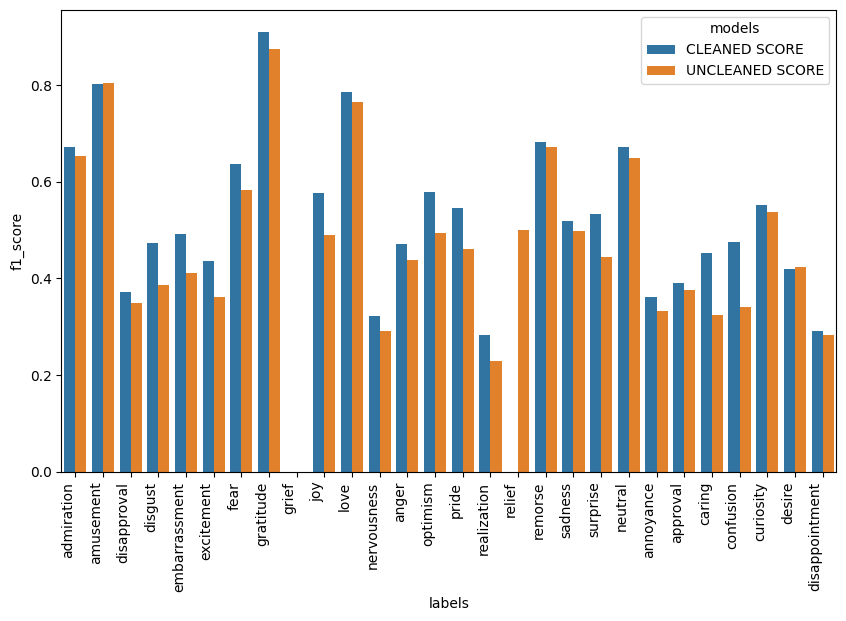

cleaned mean = 0.489169243740462
uncleaned mean = 0.46337629390048524


In [9]:

cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")

Dai risultati la data preparation sembrerebbe valida, si gha un buon miglioramento per le emozioni *grief* e *relief*

# GO Emotions: 6 emotions
We can try to map the 27 emtions to Ekman standard and finetune a new model. <br>
We compare mapping first the dataset and then training the model with training the model and mapping the results to get the better alternative

### Post-training mapping
Si riallena il modello fissando dataset post shuffle e il seme per l'inizializzaizone dei pesi


In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)
#we first shuffle the train-set
seed_val = 14
np.random.seed(seed_val)
train_df=train_df.sample(frac=1)

CHECKPOINT_MODEL_FILE=CHECKPOINT_DIR + 'bert_model_NoReg.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}




torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
                PARAMS) 

model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold}")

#now we predìct to the test values and map the results
#first we map the test set
test_df = goemotions_apply_emotion_mapping(test_df)

out= model.predict(test_df)
target= test_df.iloc[:, 1:].values
best_out = (out> threshold).astype(int)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.12


F1-score = 0.6521092002149022


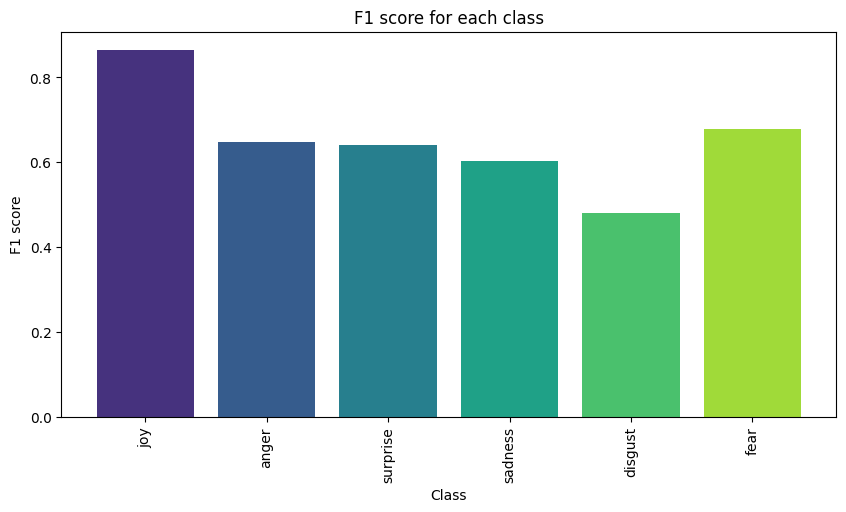

In [8]:
threshold = 0.12
best_out=goemotions_apply_emotion_mapping(best_out,isDataframe=False)
score_postMap = f1_score(target, best_out,average=None)
plot_score_barplot(target, best_out,["joy","anger","surprise","sadness","disgust","fear"])
print (f"F1-score = {np.mean(score_postMap)}")

We expect to get a better results training with a mapped tr-set because we will drop the "neutral" entries, so we will not have all the predicted "neutral" entries automatically as a false positive because the model will not be able to classify the test entries with the neutral label

### Pre mapping training

In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)
#we first shuffle the train-set
seed_val = 14
np.random.seed(seed_val)
train_df=train_df.sample(frac=1)

train_df=goemotions_apply_emotion_mapping(train_df)
val_df=goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)

CHECKPOINT_MODEL_FILE=CHECKPOINT_DIR + 'bert_model_preMapTraining.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':6
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}




torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_preMap = Bert(SCORES,
                PARAMS) 

model_preMap.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out = model_preMap.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold_premap, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold_premap}")

out= model_preMap.predict(test_df)
target= test_df.iloc[:, 1:].values
best_out = (out> threshold_premap).astype(int)


c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:53: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:53: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:53: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:53: FutureWarning: Operation between non bool

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Threshold = 0.27


F1-score = 0.6786036795159606


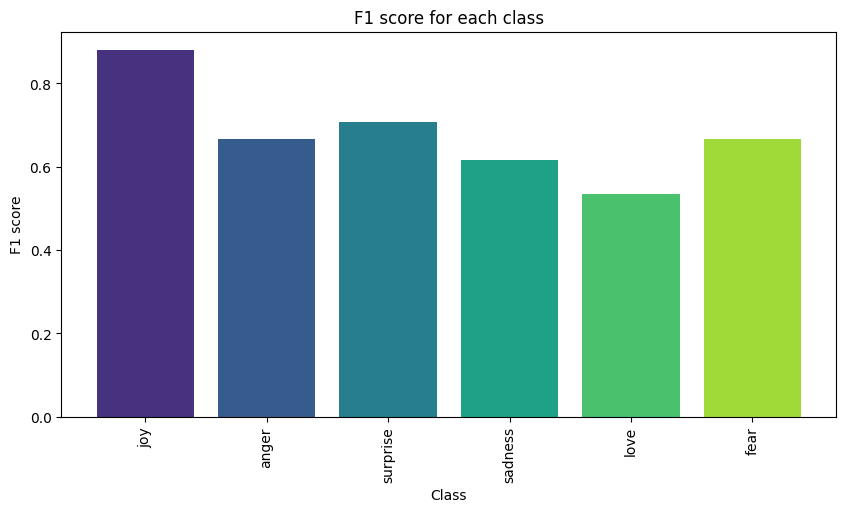

In [5]:
threshold_premap = 0.27
score_postMap = f1_score(target, best_out,average=None)
plot_score_barplot(target, best_out,["joy","anger","surprise","sadness","love","fear"])
print (f"F1-score = {np.mean(score_postMap)}")